In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/food segmentation

/content/drive/MyDrive/food segmentation


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Read the dataset/s
df = pd.read_csv('/content/drive/MyDrive/food segmentation/masks_info.csv')

In [5]:
#Checking discription
df.head

<bound method NDFrame.head of           Element;Colour
0     crust_edge;#99d9ea
1  charred_crust;#ff3a3a
2        sausage;#d3ead3
3            ham;#ff9500
4    ground_beef;#50acf3
5         tomato;#fff1cc
6         olives;#ff95d2
7      mushrooms;#bcff7b>

In [6]:
df.tail

<bound method NDFrame.tail of           Element;Colour
0     crust_edge;#99d9ea
1  charred_crust;#ff3a3a
2        sausage;#d3ead3
3            ham;#ff9500
4    ground_beef;#50acf3
5         tomato;#fff1cc
6         olives;#ff95d2
7      mushrooms;#bcff7b>

In [7]:
df.shape

(8, 1)

In [8]:
df.columns

Index(['Element;Colour'], dtype='object')

In [9]:
df.nunique()

Element;Colour    8
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Element;Colour  8 non-null      object
dtypes: object(1)
memory usage: 192.0+ bytes


In [19]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model

# paths
image_path = '/content/drive/MyDrive/food segmentation/Food Segmentation/images'
mask_path = '/content/drive/MyDrive/food segmentation/Food Segmentation/masks'
mask_info_path = '/content/drive/MyDrive/food segmentation/masks_info.csv'

# Load the mask info
mask_info = pd.read_csv(mask_info_path)


# Load the image and mask filenames
image_filenames = os.listdir(image_path)[:16]
mask_filenames = os.listdir(mask_path)[:16]

# Initialize empty lists to store the images and masks
images = []
masks = []

# Iterate over the filenames and load the images and masks
for img_filename, mask_filename in zip(image_filenames, mask_filenames):
    img = Image.open(os.path.join(image_path, img_filename))
    img = img.convert('RGB')
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    images.append(img_array)

    mask = Image.open(os.path.join(mask_path, mask_filename))
    mask = mask.convert('RGB')
    mask = mask.resize((256, 256)) 
    mask_array = np.array(mask) / 255.0
    masks.append(mask_array)

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Define the U-Net model architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expanding Path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # output layer
    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)


    # Create the model
    model = Model(inputs, outputs)

    return model
    

# input size of the images
input_size = (256, 256, 3) 

# Create U-Net model
model = unet_model(input_size)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# Train the model
model.fit(X_train, y_train, batch_size=16, epochs=4, validation_data=(X_test, y_test))

# Save model
model.save('/content/drive/MyDrive/food segmentation/saved_model.h5')


(12, 256, 256, 3) (12, 256, 256, 3)
(4, 256, 256, 3) (4, 256, 256, 3)
Epoch 1/4
1/1 [==============================] - 120s 120s/step - loss: 0.6962 - accuracy: 0.2874 - val_loss: 0.6017 - val_accuracy: 0.3622
Epoch 2/4
1/1 [==============================] - 125s 125s/step - loss: 0.6050 - accuracy: 0.2896 - val_loss: 56.5150 - val_accuracy: 0.3598
Epoch 3/4
1/1 [==============================] - 112s 112s/step - loss: 89.3333 - accuracy: 0.2884 - val_loss: 0.5315 - val_accuracy: 0.3622
Epoch 4/4


KeyboardInterrupt: ignored

1/1 [==============================] - 9s 9s/step
(4, 256, 256, 3)


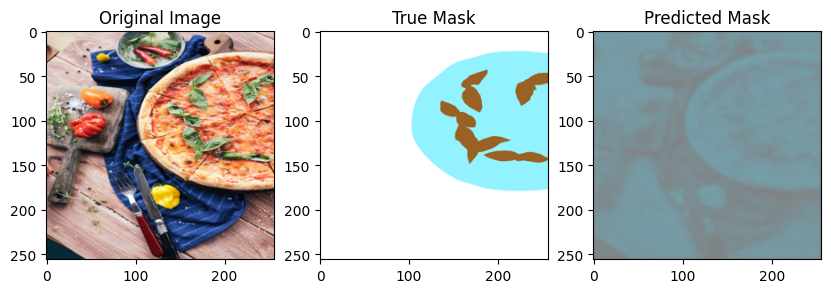

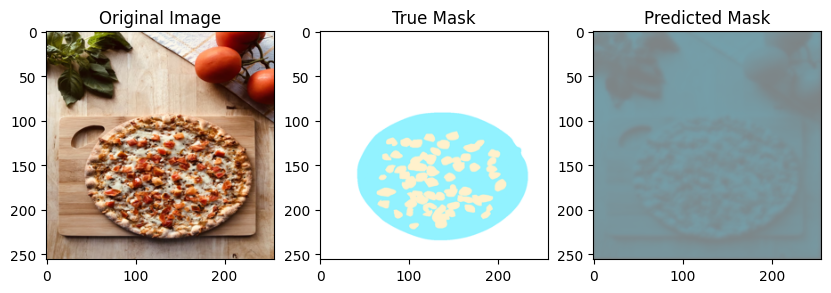

In [20]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from PIL import Image
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt

# paths
image_path = '/content/drive/MyDrive/food segmentation/Food Segmentation/images'
mask_path = '/content/drive/MyDrive/food segmentation/Food Segmentation/masks'
mask_info_path = '/content/drive/MyDrive/food segmentation/masks_info.csv'

# Load the mask info
mask_info = pd.read_csv(mask_info_path)

# Load the image and mask filenames
image_filenames = sorted(os.listdir(image_path))[-4:]
mask_filenames = sorted(os.listdir(mask_path))[-4:]

# empty lists to store the images and masks
images = []
true_masks = []
predicted_masks = []

# Iterate over the filenames and load the images and masks
for img_filename, mask_filename in zip(image_filenames, mask_filenames):
    # Load and preprocess the image
    img = Image.open(os.path.join(image_path, img_filename))
    img = img.convert('RGB')
    img = img.resize((256, 256))
    img_array = np.array(img, dtype=np.float32) / 255.0
    images.append(img_array)

    # Load and preprocess the true mask
    mask = Image.open(os.path.join(mask_path, mask_filename))
    mask = mask.convert('RGB')
    mask = mask.resize((256, 256))
    mask_array = np.array(mask, dtype=np.float32) / 255.0
    true_masks.append(mask_array)

# Convert to numpy arrays
images = np.array(images)
true_masks = np.array(true_masks)


# input size of the images
input_size = (256, 256, 3)

# Load the trained model
model = load_model('/content/drive/MyDrive/food segmentation/saved_model.h5')

# generate predicted masks
predicted_masks = model.predict(images)
print(predicted_masks.shape)


# Plot the original images, true masks, and predicted masks
for i in range(len(images)):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[1].imshow(true_masks[i])
    axes[1].set_title('True Mask')
    axes[2].imshow(predicted_masks[i])
    axes[2].set_title('Predicted Mask')
    plt.show()


In [ ]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import tkinter as tk

model = load_model('saved_model.h5')




gui = tk.Tk()
gui.title = 'Pizza Segmenter'
gui.geometry = '550 x 350'

instructions = tk.Label(text = "Place image in same folder as main.py, enter file name in box below e.g. test.jpg")
instructions.grid(row=0, column=0, columnspan=3)

entry = tk.Entry()
entry.grid(row=1, column=0, columnspan=3)

def segment():
    imgName = entry.get()
    try:
        img = cv2.imread(imgName)
        print(img.max())
        img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)[:,:,::-1]/255.0
        img = np.array([img])
        img = model.predict(img)
        img = img[0]
        cv2.imwrite("out.png", img[:,:,::-1]*255)
        

        plt.figure()
        plt.imshow(img)
        plt.show()
        
    except:
        entry.delete(0, tk.END)
        entry.insert(tk.END, "Incorrect file name")


segment = tk.Button(text='Segment', command = segment)
segment.grid(row=2, column=0, columnspan=3)




gui.mainloop()